<img src="../../data/images/gempy_logo.png" />

# <center> From Maps to Models - Tutorials for structural geological modeling using GemPy and GemGIS</center>

# Model 4 - Unconformable/Truncated Layers

The fourth and last notebook in this tutorial series builds upon the builds upon the [previous three notebooks](../01_basic_modeling) ([previous three notebooks on Github](https://nbviewer.org/github/cgre-aachen/gemgis_data/tree/main/notebooks/01_basic_modeling)) where parallel horizontal, parallel folded and parallel faulted layers were modeled. This notebook illustrates now how to create a simple model of unconformable layers in `GemPy`. The model consists of four layers of which only two are always parallel. These two groups (`Series`) of parallel layers are separated and truncated by an unconformity. The model has an extent of 1000 m by 1000 m with a vertical extent of 600 m. 

<div class="alert alert-block alert-success">
<b>In this tutorial, you will learn the following:</b> <br>
- Get an understanding of how unconformities are modeled/displayed in GemPy<br>
- How to build a simple model consisting of <b>unconformable layers</b> belonging to <b>multiple Series</b><br>

</div>

## Contents

1. [Installing GemPy](#installing-gempy)
2. [Importing Libraries](#importing-libraries)
3. [Data Preparation](#data-preparation)
    1. [Importing Interface Points](#importing-interface-points)
    2. [Importing Orientations](#importing-orientations)
4. [GemPy Model Calculation](#gempy-model-calculation)
    1. [Creating the GemPy Model](#creating-the-gempy-model)
    2. [Inspecting the Surfaces](#inspecting-the-surfaces)
    3. [Inspecting the Input Data](#inspecting-the-input-data)
    4. [Map Stack to Surfaces](#map-stack-to-surfaces)
    5. [Plotting Input Data in 2D](#plotting-the-input-data-in-2d)
    6. [Plotting Input Data in 3D](#plotting-the-input-data-in-3d)
    7. [Setting the Interpolator](#setting-the-interpolator)
    8. [Computing the Model](#computing-the-model)
5. [Model Visualization and Post-Processing](#model-visualization-and-post-processing)
    1. [Visualizing Cross Sections of the Computed Model](#visualizing-cross-sections-of-the-computed-model)
    2. [Visualizing the computed model in 3D](#visualizing-the-computed-model-in-3d)
6. [Conclusions](#conclusions)
7. [Outlook](#outlook)
8. [Licensing](#licensing)



<img src="../images/model4.png" width=500/>

Unconformities are the last element that `GemPy` is capable of modeling apart from folded and faulted layers. Unconformities are not calculated as a fault surface that offsets layers. Instead, a new scalar field is calculated, which is merged with other scalar fields. In order to create another scalar field, the layers just have to be defined as non-parallel layers in `gp.map_stack_to_surfaces()` by defining multiple `Series`. 

<img src="../../data/images/model3_fig1.PNG" width=500/>
Source: <a href="https://doi.org/10.5194/gmd-12-1-2019">de la Varga et al. (2019)</a>

<a id='installing-gempy'></a>

# Installing GemPy

If you have not installed `GemPy` yet, please follow the [installation instructions](https://docs.gempy.org/installation.html). If you encounter any issues, feel free to open a new discussion at [GemPy Discussions](https://github.com/cgre-aachen/gempy/discussions). If you encounter an error in the installation process, feel free to also open an issue at [GemPy Issues](https://github.com/cgre-aachen/gempy/issues). There, the `GemPy` development team will help you out. 

<a id='importing-libraries'></a>

# Importing Libraries

For this notebook, we need the `pandas` library for the data preparation, `matplotlib` for plotting and of course the `gempy` library. The `gempy_viewer` library is used to plot the modeling results. Any warnings that may appear can be ignored for now. 

In [1]:
import pandas as pd
import gempy as gp
import gempy_viewer as gpv
import matplotlib.pyplot as plt

Setting Backend To: AvailableBackends.numpy


<a id='data-preparation'></a>
# Data Preparation

For this model, the only thing that needs to be done is loading the already created interface points and orientations. In the next tutorials, you will create the data yourself and process it further to make it usable for GemPy. 

<a id='importing-interface-points'></a>
## Importing Interface Points

We are using the `pandas` library ([Pandas](https://pandas.pydata.org/docs/)) to load the interface points that were prepared beforehand and stored as CSV-file (comma-separated-file). The only information that is needed are the location of the interface point (`X`, `Y`, `Z`) and the `formation` it belongs to. You may have to adjust the `delimiter` (`'\t'`, `','`, `';'`, `' '`) when loading the file.

In [2]:
interfaces = pd.read_csv('../../data/model4/model4_interfaces.csv', 
                         delimiter = ';')
interfaces.head()

,X,Y,Z,formation
0,200,250,-150,Layer1
1,200,500,-150,Layer1
2,200,750,-150,Layer1
3,800,250,-150,Layer1
4,800,500,-150,Layer1


<a id='importing-orientations'></a>

## Importing Orientations

The orientations will also be loaded using `pandas`. In addition to the location and the formation the orientation belongs to, the dip value, azimuth value (dip direction) and a polarity value (mostly set to 1 by default) needs to be provided. As the model will feature folded layers, the dip and the azimuth are variable. Orientations are provided for all four modeled layers. 

In [3]:
orientations = pd.read_csv('../../data/model4/model4_orientations.csv', 
                           delimiter=';')
orientations.head()

,X,Y,Z,formation,dip,azimuth,polarity
0,200,500,-150,Layer1,0,0,1
1,800,500,-150,Layer1,0,0,1
2,500,500,-150,Layer1,0,0,1
3,500,250,-350,Layer3,45,90,1
4,500,500,-350,Layer3,45,90,1


<a id='gempy-model-calculation'></a>

# GemPy Model Calculation

The following part presents the main steps of creating a model in `GemPy`. 

The creation of a `GemPy` Model follows particular steps which will be performed in the following:

1. Create new model and data initiation: `gp.create_geomodel()`
2. Map Stack to Surfaces: `gp.map_stack_to_surfaces()`
3. [...]
4. Computing the Model: `gp.compute_model()`

<a id='creating-the-gempy-model'></a>

## Creating the GemPy Model

The first step is to create a new empty `GemPy` model by providing a name for it. 

In addition, the `extent` of the model (`xmin`, `xmax`, `ymin`, `ymax`, `zmin`, `zmax`) and the `resolution` in `X`, `Y`and `Z` direction (`res_x`, `res_y`, `res_z`, equal to the number of cells in each direction) will be set using lists of values. If you want to provide cells with a certain size, you would have to calculate the following. It is important to convert the resulting number of cells into an `int` as only integer values for the number of cells are valid. 

```python
res_x = int((xmax-xmin)/cell_size_x)
res_y = int((ymax-ymin)/cell_size_y)
res_z = int((zmax-zmin)/cell_size_z)
```

The interface points (`surface_points_df`) and orientations (`orientations_df`) will be passed as strings with the location of the CSV files. Please mind that you may have to edit the `pandas_reader_kwargs` by adding the `'sep'` key and the delimiter `';'` as item of a dictionary.

In [4]:
geo_model: gp.data.GeoModel = gp.create_geomodel(
    project_name='Model4_Truncated_Layers',
    extent=[0, 1000, 0, 1000, -600, 0], 
    resolution=[100, 100, 100],  # * Here we define the number of octree levels. If octree levels are defined, the resolution is ignored.
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations='../../data/model4/model4_orientations.csv',
        path_to_surface_points='../../data/model4/model4_interfaces.csv',
        pandas_reader_kwargs = {'sep': ';'}
    )
)

<a id='inspecting-the-surfaces'></a>

## Inspecting the Surfaces

The model consists of four different layers or surfaces now which all belong to the `Default series`. During the next step, the proper `Series` will be assigned to the surfaces. Using the `structural_frame`-attribute again, we can check which layers were loaded.

In [5]:
geo_model.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formation,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Layer1,
	color=#015482,
	is_active=True
),
Element(
	name=Layer2,
	color=#9f0052,
	is_active=True
),
Element(
	name=Layer3,
	color=#ffbe00,
	is_active=True
),
Element(
	name=Layer4,
	color=#728f02,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

<a id='inspecting-the-input-data'></a>

## Inspecting the Input Data

The loaded interface points and orientations can again be inspected using the `surface_points_copy`- and `orientations_copy`-attributes. Using the `df`-attribute of this object will convert the displayed table in a `pandas` `DataFrame`.

In [6]:
geo_model.surface_points_copy.df.head()

,X,Y,Z,id,nugget
0,200.0,250.0,-150.0,6808710,0.00002
1,200.0,500.0,-150.0,6808710,0.00002
2,200.0,750.0,-150.0,6808710,0.00002
3,800.0,250.0,-150.0,6808710,0.00002
4,800.0,500.0,-150.0,6808710,0.00002


In [7]:
geo_model.orientations_copy.df.head()

,X,Y,Z,G_x,G_y,G_z,id,nugget
0,200.0,500.0,-150.0,0.000000,0.000000e+00,1.000000,6808710,0.01
1,800.0,500.0,-150.0,0.000000,0.000000e+00,1.000000,6808710,0.01
2,500.0,500.0,-150.0,0.000000,0.000000e+00,1.000000,6808710,0.01
3,500.0,250.0,-350.0,0.707107,4.329780e-17,0.707107,210743622,0.01
4,500.0,500.0,-350.0,0.707107,4.329780e-17,0.707107,210743622,0.01


<a id='map-stack-to-surfaces'></a>

## Map Stack to Surfaces

During this step, the layers are assigned their respective `Series`. As `Layer1` and `Layer2` are parallel, they will be defined as one `Series`. However, they are not parallel to `Layer3` and `Layer4` (which are in itself parallel) and will therefore be defined in a separate series. The order within one series also defines the age relations within this series and has to be according to the depositional events of the layers.

In [8]:
gp.map_stack_to_surfaces(gempy_model=geo_model,
                         mapping_object=
                         {
                          'Strata1': ('Layer1', 'Layer2'),      
                          'Strata2': ('Layer3', 'Layer4'),
                         },
                         remove_unused_series=True)
geo_model.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strata1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Layer1,
	color=#015482,
	is_active=True
),
Element(
	name=Layer2,
	color=#9f0052,
	is_active=True
)
]
),
StructuralGroup(
	name=Strata2,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=Layer3,
	color=#ffbe00,
	is_active=True
),
Element(
	name=Layer4,
	color=#728f02,
	is_active=True
)
]
)
],
	fault_relations=
[[False, False],
 [False, False]],

<a id='plotting-the-input-data-in-2d'></a>

## Plotting the input data in 2D using Matplotlib

The input data can now be visualized in 2D using `matplotlib`. This might for example be useful to check if all points and measurements are defined the way we want them to. Using the function `plot_2d()`, we attain a 2D projection of our data points onto a plane of chosen direction (we can choose this attribute to be either `'x'`, `'y'`, or `'z'`).

C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_viewer\API\_plot_2d_API.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


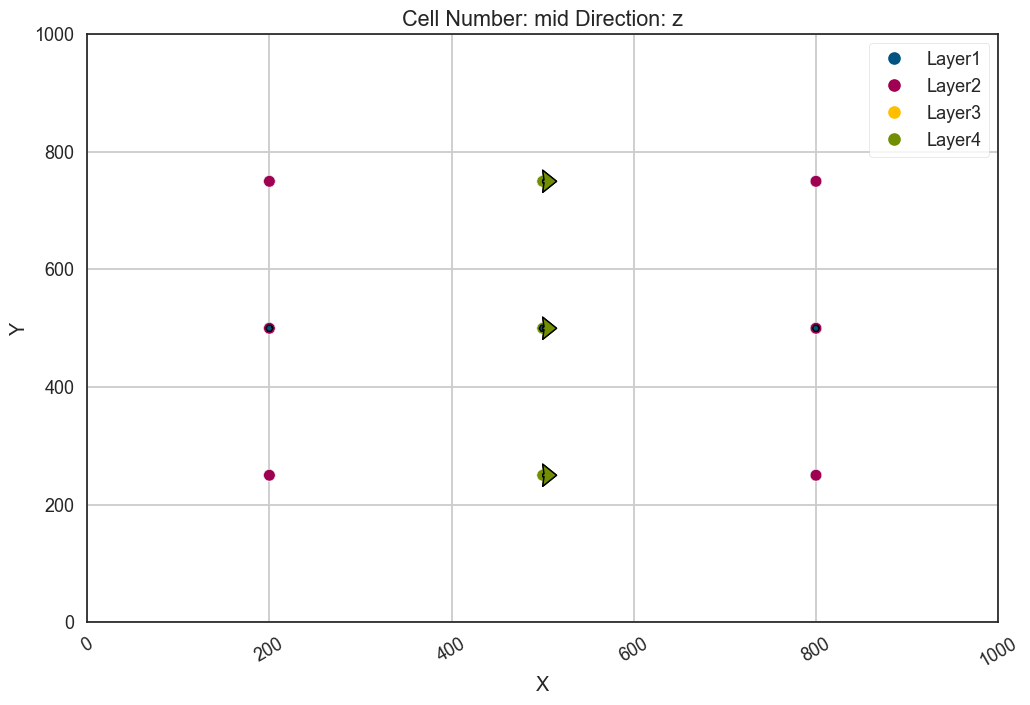

In [9]:
gpv.plot_2d(geo_model, 
           direction='z', 
           show_lith=False, 
           show_boundaries=False)
plt.grid()

<a id='plotting-the-input-data-in-3d'></a>

## Plotting the input data in 3D using PyVista

The input data can also be viszualized using the `pyvista` package. In this view, the interface points are visible as well as the orientations (marked as arrows) which indicate the normals of each orientation value. 

The `pyvista` package requires the Visualization Toolkit (VTK) to be installed.

C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


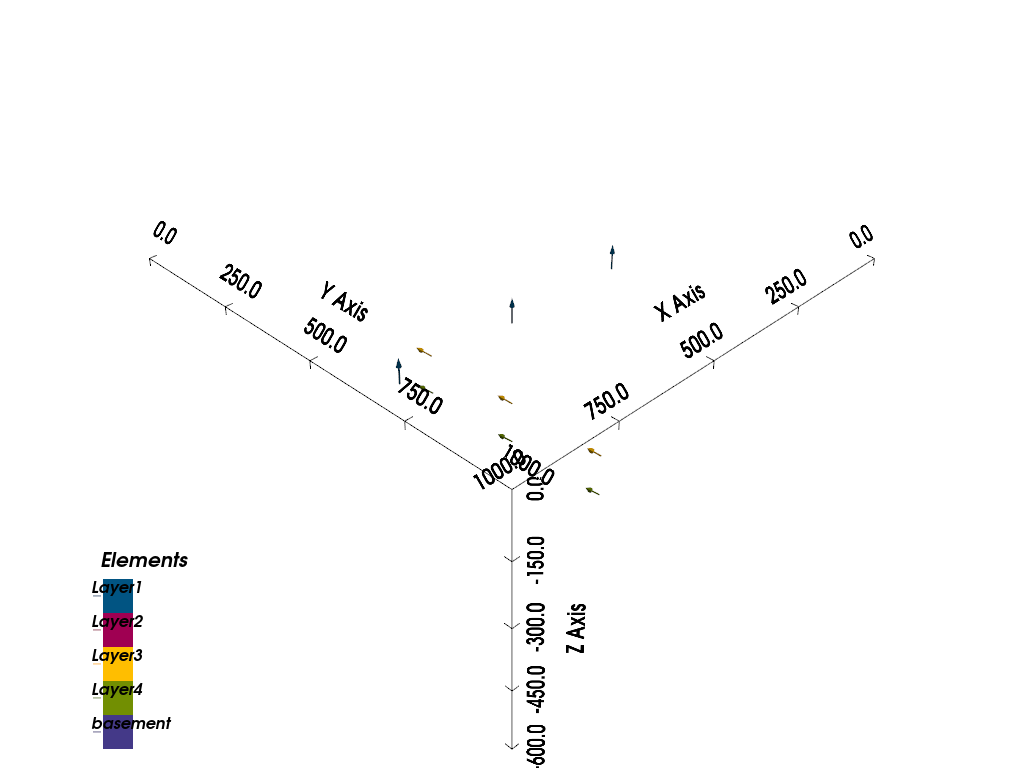

In [10]:
gpv.plot_3d(geo_model, 
            image=False, 
            show_lith=False,
            plotter_type='basic',
            kwargs_plotter= {'notebook':True},)

<a id='setting-the-interpolator'></a>
## Setting the interpolator

Unlike previous versions, GemPy 3 doesn’t rely on theano or asera. Instead, it utilizes numpy or tensorflow. Consequently, we no longer need to recompile all theano functions (TensorFlow uses eager execution; we found no notable speed difference after profiling the XLA compiler).

The parameters used for the interpolation are stored in gempy.core.data.GeoModel.interpolation_options. These parameters have sensible default values that you can modify if necessary. However, we advise caution when changing these parameters unless you fully understand their implications.

Display the current interpolation options 

In [11]:
geo_model.interpolation_options

InterpolationOptions(kernel_options=KernelOptions(range=1.7, c_o=10.0, uni_degree=1, i_res=4.0, gi_res=2.0, number_dimensions=3, kernel_function=AvailableKernelFunctions.cubic, kernel_solver=Solvers.DEFAULT, compute_condition_number=False, optimizing_condition_number=False, condition_number=None), evaluation_options=EvaluationOptions(_number_octree_levels=1, _number_octree_levels_surface=4, octree_curvature_threshold=-1.0, octree_error_threshold=1.0, octree_min_level=2, mesh_extraction=True, mesh_extraction_masking_options=<MeshExtractionMaskingOptions.INTERSECT: 3>, mesh_extraction_fancy=True, evaluation_chunk_size=500000, compute_scalar_gradient=False, verbose=False), debug=True, cache_mode=<CacheMode.IN_MEMORY_CACHE: 3>, cache_model_name='Model4_Truncated_Layers', block_solutions_type=<BlockSolutionType.DENSE_GRID: 2>, sigmoid_slope=5000000, debug_water_tight=False)

<a id='computing-the-model'></a>

## Computing the model

At this point, we have all we need to compute our full model via `gp.compute_model()`. By default, this will return two separate solutions in the form of arrays. The first provides information on the lithological formations, the second on the fault network in the model, which is not present in this example. 

In [12]:
sol = gp.compute_model(geo_model, 
                       compute_mesh=True)

Setting Backend To: AvailableBackends.numpy
Chunking done: 57 chunks


C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))


Chunking done: 51 chunks


C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_engine\modules\activator\_soft_segment.py:95: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + bt.t.exp(x))


<a id='model-visualization-and-post-processing'></a>

# Model Visualization and Post-Processing

<a id='visualizing-cross-sections-of-the-computed-model'></a>

## Visulazing Cross Sections of the computed model

Cross sections in different `direction`s and at different `cell_number`s can be displayed. Here, we see the horizontal layers in the one direction and the truncated layers in the other direction.

C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_viewer\API\_plot_2d_API.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


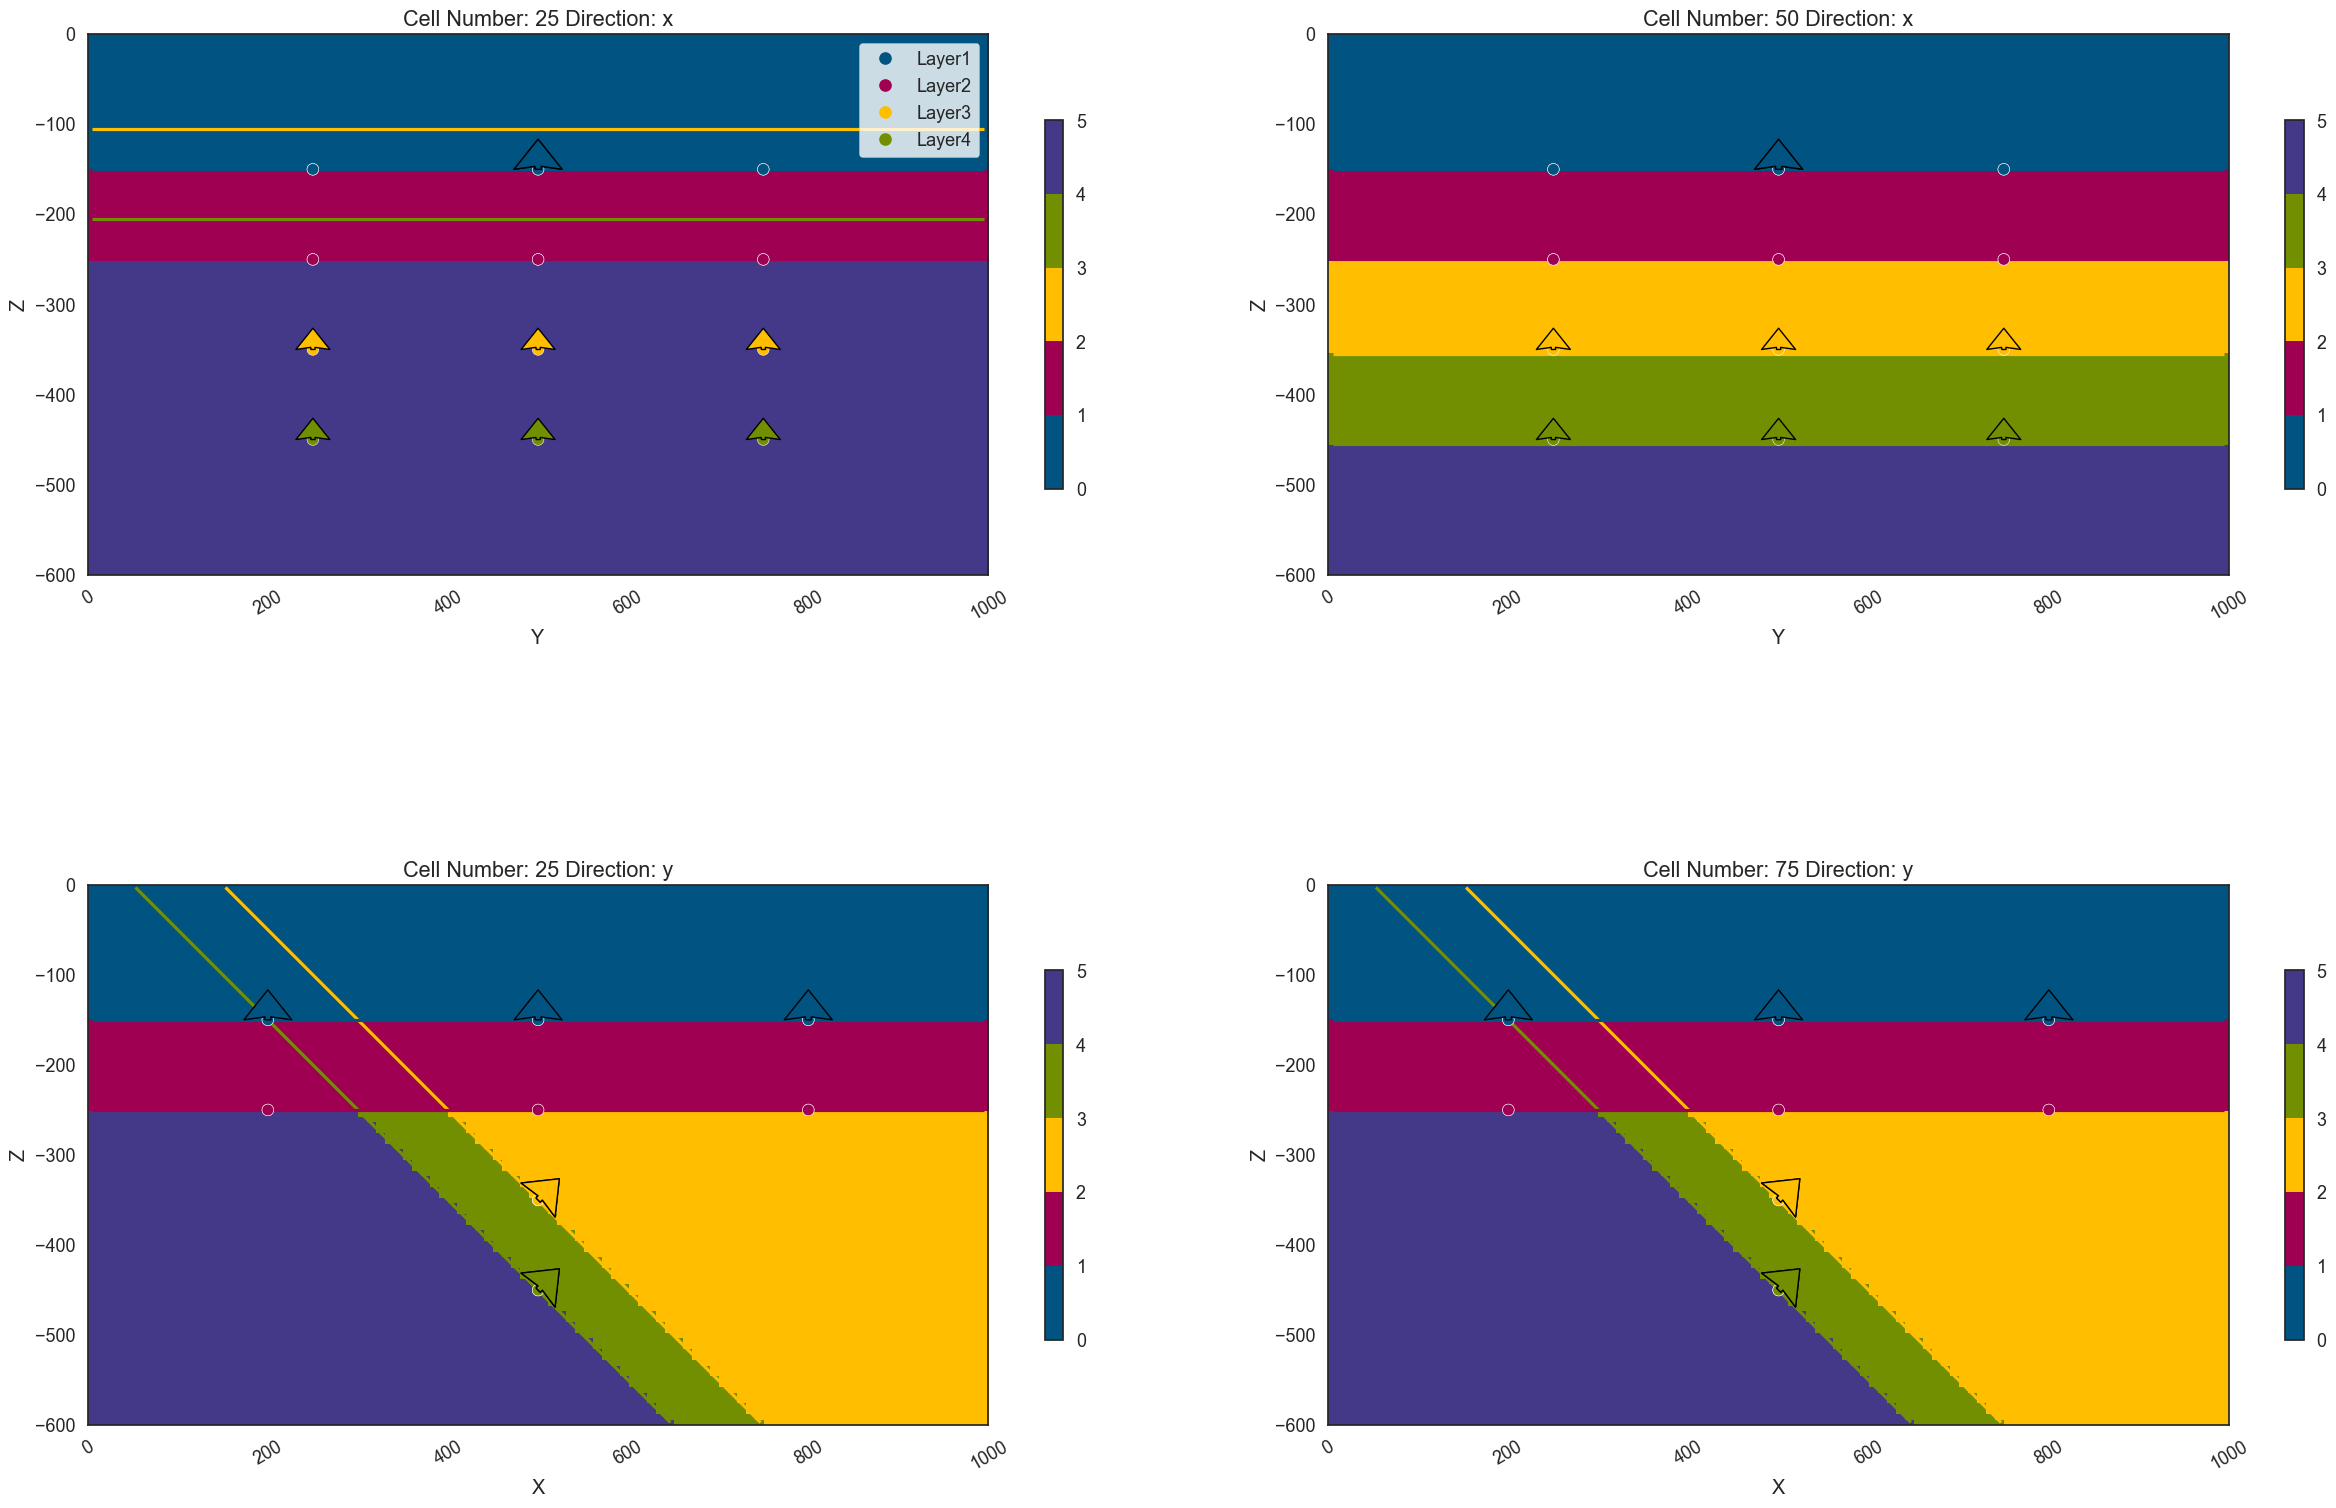

In [13]:
gpv.plot_2d(geo_model, 
           direction=['x', 'x', 'y', 'y'], 
           cell_number=[25, 50, 25, 75], 
           show_topography=False, 
           show_data=True)

Next to the lithology data, we can also plot the calculated scalar field.

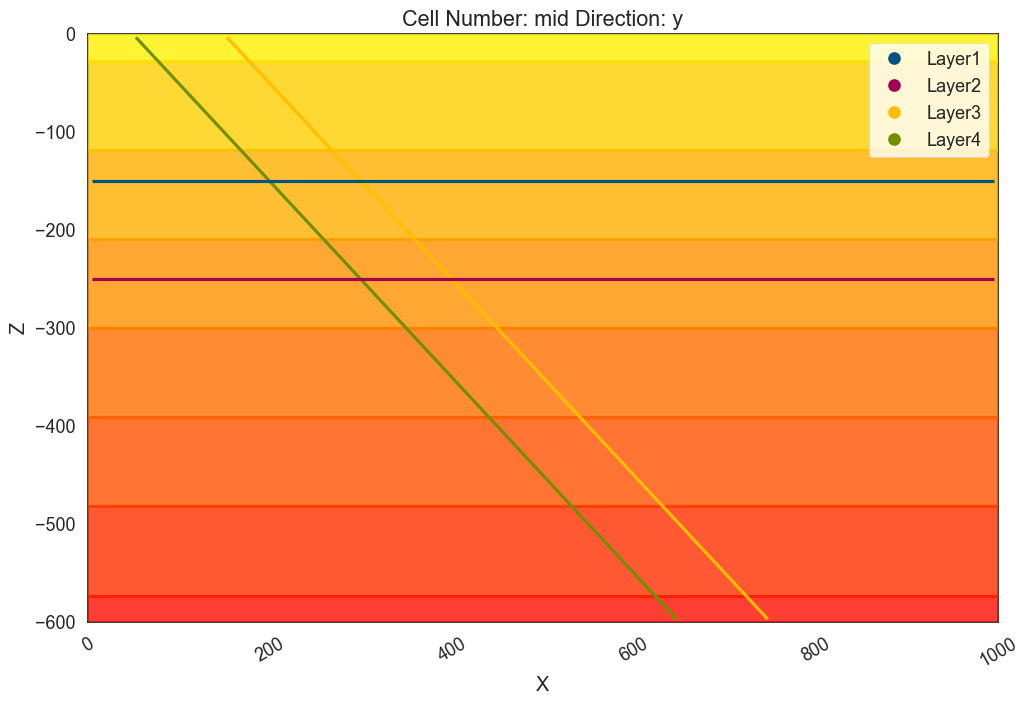

In [14]:
gpv.plot_2d(geo_model, direction='y', show_data=False, show_scalar=True, show_lith=False)

<a id='visualizing-the-computed-model-in-3d'></a>

# Visualizing the computed model in 3D

The computed model can be visualized in 3D using the `pyvista` library. Setting `kwargs_plotter= {'notebook':True}` will open an interactive windows and the model can be rotated and zooming is possible. 

C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\gempy_viewer\modules\plot_3d\drawer_surfaces_3d.py:38: PyVistaDeprecationWarning: 
../../../../Anaconda3/envs/gemgis_12/Lib/site-packages/gempy_viewer/modules/plot_3d/drawer_surfaces_3d.py:38: Argument 'color' must be passed as a keyword argument to function 'BasePlotter.add_mesh'.
From version 0.50, passing this as a positional argument will result in a TypeError.
  gempy_vista.surface_actors[element.name] = gempy_vista.p.add_mesh(
C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\ale93371\Anaconda3\envs\gemgis_12\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


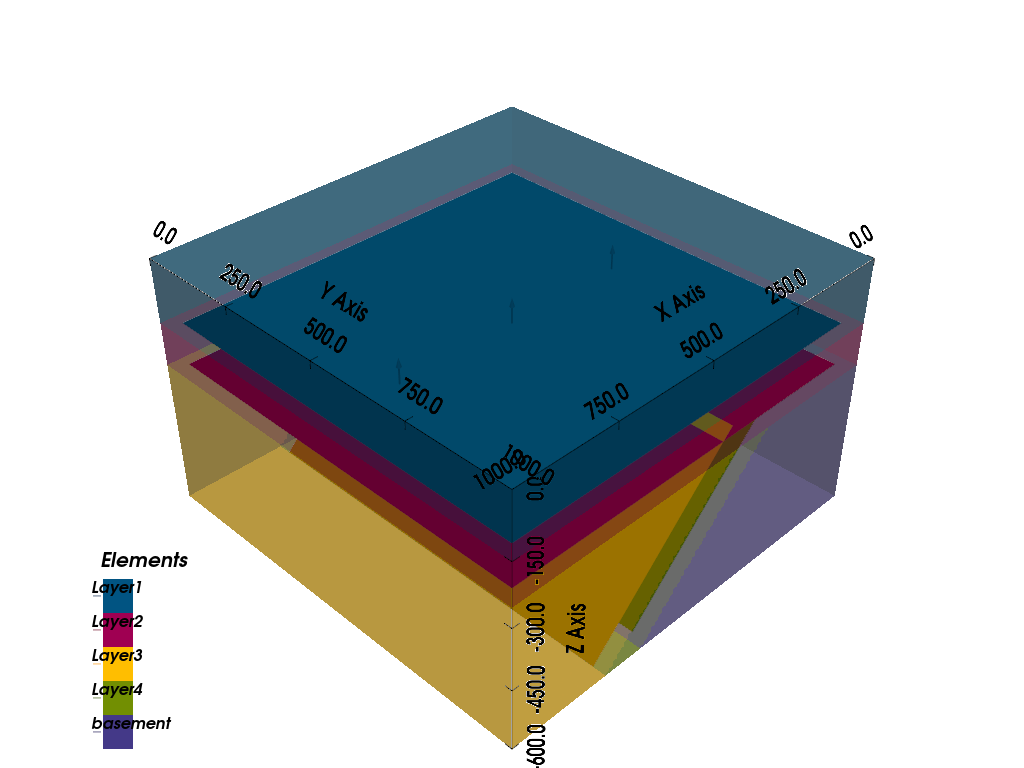

In [15]:
gpv.plot_3d(geo_model, 
                 image=False, 
                 show_topography=True,
                 plotter_type='basic', 
                 kwargs_plotter= {'notebook':True},
                 show_lith=True)

<a id='conclusions'></a>
# Conclusions

This is the last notebook of the `Basic Modeling` module. After completing this module, you should be able to model parallel and non-parallel, folded, faulted, and unconformable layers.

<div class="alert alert-block alert-success">
<b>In this tutorial, you have learnt the following:</b> <br>
- Get an understanding of how unconformities are modeled/displayed in GemPy<br>
- How to build a simple model consisting of <b>unconformable layers</b> belonging to <b>multiple Series</b><br>

</div>


<a id='outlook'></a>
# Outlook

All following notebooks represent the main part of the `From Maps to Models` tutorial series. There, we also introduce the `GemGIS` library, which will be a huge part of the following notebooks extending your knowledge about spatial data processing and creating input data for the `GemPy` modeling. 


[Take me to the next notebook on Github](https://nbviewer.org/github/cgre-aachen/gemgis_data/blob/main/notebooks/00_introduction_to_working_with_gemgis.ipynb)

[Take me to the next notebook locally](../00_introduction_to_working_with_gemgis.ipynb)

<img src="../../jose/images/fig1.png" />

<a id='licensing'></a>

## Licensing

Institute for Computational Geoscience, Geothermics and Reservoir Geophysics, RWTH Aachen University & Fraunhofer IEG, Fraunhofer Research Institution for Energy Infrastructures and Geotechnologies IEG, Authors: Alexander Juestel. For more information contact: alexander.juestel(at)ieg.fraunhofer.de

All notebooks are licensed under a Creative Commons Attribution 4.0 International License (CC BY 4.0, http://creativecommons.org/licenses/by/4.0/). References for each displayed map are provided. Most of the maps originate from the books of [Powell (1992)](https://link.springer.com/book/9783540586074) and [Bennison (1990)](https://link.springer.com/book/10.1007/978-1-4615-9630-1). References for maps with unknown origin will gladly be added.